In [1]:
from vampyr import vampyr3d as vp
import numpy as np
import matplotlib.pyplot as plt

what do you want to show in the first part? 

1. Plot scaling functions at zeroth scale
2. Show translation and dilation of scaling functions
3. Do 1 and 2 for wavelet functions

# Scaling and wavelet functions

First we need to select our scaling functions $\{\phi_i\}_{i=0}^k$. In general we choose or scaling functions $\phi_i$to be either [Legendre Polynomials](https://en.wikipedia.org/wiki/Legendre_polynomials) or [Interpolating Polynomials](https://en.wikipedia.org/wiki/Polynomial_interpolation). I'll use Legendre Polynomials in these examples.

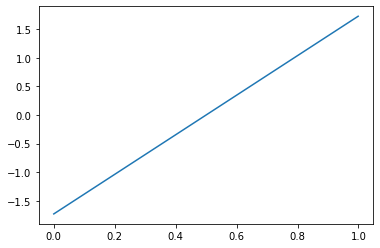

In [2]:
from vampyr import LegendreBasis

basis_set = LegendreBasis(5)
scaling = basis_set.scaling


x = np.arange(0.0, 1.0, 0.001)
y = [scaling(i=1)([_]) for _ in x]
plt.plot(x, y)

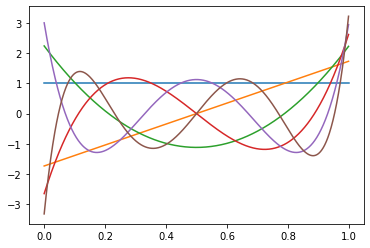

In [3]:
x = np.arange(0.0, 1.0, 0.001)
for i in range(6):
    y = [scaling(i=i)([x]) for x in x]
    plt.plot(x, y)

Let's have a MultiResolution of of these scaling functions, we do this by dilation and translation

\begin{align}
    \phi_{i, l}^n(x) &= 2^{n/2} \phi_i(2^nx - l)
\end{align}

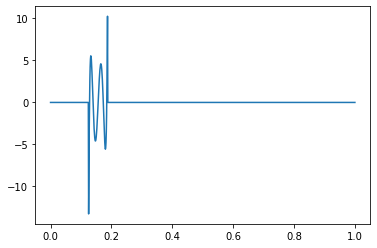

In [4]:
x = np.arange(0.0, 1.0, 0.001)
y = [scaling(i=i, l=2, n=4)([x]) for x in x]
plt.plot(x, y)

Now let's introduce our wavelet functions $\psi_{i, l}^n$. They are connected to the scaling functions through the two-scale difference relation:

\begin{align}
\phi_i(x) = \sqrt{2} \sum_j h^{(0)}_{ij} \phi_j(2x) + h^{(1)}_{ij} \phi_j(2x-1) \\
\psi_i(x) = \sqrt{2} \sum_j g^{(0)}_{ij} \phi_j(2x) + g^{(1)}_{ij} \phi_j(2x-1) \\
\end{align}


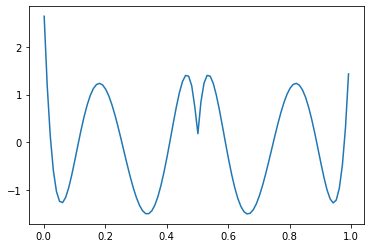

In [5]:
wavelet = basis_set.wavelet


x = np.arange(0.001, 1.0, 0.01)
y = [wavelet(i=2)([_]) for _ in x]
plt.plot(x, y)

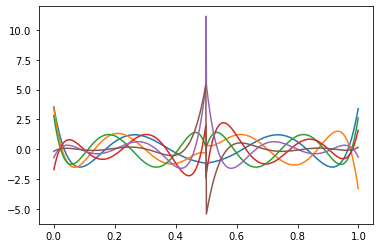

In [6]:
x = np.arange(0.0, 1.0, 0.001)
for i in range(6):
    y = [wavelet(i=i, n=0)([x]) for x in x]
    plt.plot(x, y)

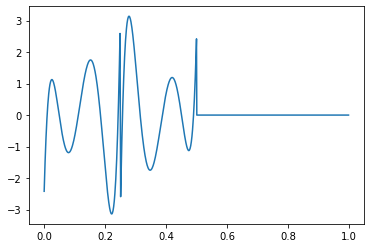

In [7]:
x = np.arange(0.0, 1.0, 0.001)
y = [wavelet(i=3, l=0, n=1)([x]) for x in x]
plt.plot(x, y)

# Scaling Projectors


Let's introduce the Scaling Projectior $P^n_k$. This operator projects the function $f$ onto the
scaling basis $\{\phi_{j,l}^n\}$. I.e.,

\begin{align}
f^n(x) = P^n_k [f(x)] = \sum_{l=0}^{2^n-1} \sum_{j=0}^k s_{j, l}^{n,f} \phi_{j,l}^n(x) 
\end{align}


Let's use it and plot some functions

What do you want to do in this part?

1. Introduce the ScalingProjector
2. Show which basis is used when we use the scaling projector
3. Plot a gaussian then comare it to P^n[f(x)], show how the approximation improves
4. Introduce the WaveletProjector
5. Show how it is related to the scaling projector
6. Introduce the error tresholding
7. Plot a Gaussian then compare uniform projector with adaptive
8. Plot and compare grids

We begin with making an analytical gaussian function

In [8]:
from vampyr import vampyr3d as vp

r0 = [0.8, 0.8, 0.8]
beta = 100.0 # Do 100 and 1000000
alpha = (beta / np.pi) ** (3 / 2.0)
f = vp.GaussFunc(coef=alpha, exp=beta, pos=r0)

# PS: They will show a better way to do analytical functions during the exercises.

In [9]:
mra = vp.MultiResolutionAnalysis(box=[0, 2], order=5)

P0 = vp.ScalingProjector(mra, 0) # P^0_k
P1 = vp.ScalingProjector(mra, 1) # P^1_k
P2 = vp.ScalingProjector(mra, 2) # P^2_k
P3 = vp.ScalingProjector(mra, 3) # P^3_k
P4 = vp.ScalingProjector(mra, 4) # P^4_k

f0 = P0(f) #f^0 = P^0_k[f]
f1 = P1(f) #f^1 = P^1_k[f]
f2 = P2(f) #f^2 = P^2_k[f]
f3 = P3(f) #f^3 = P^3_k[f]
f4 = P4(f) #f^4 = P^4_k[f]

Next let's show you what the basis we project onto looks like

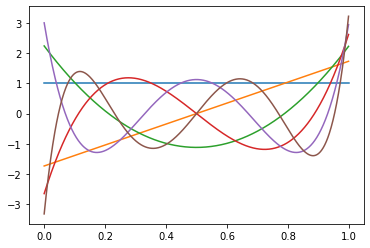

In [10]:
n = 0
x = np.arange(0.0, 1.0, 0.001)
for l in range(2**n):
    for i in range(6):
        y = [scaling(i=i, l=l, n=n)([x]) for x in x]
        plt.plot(x, y)

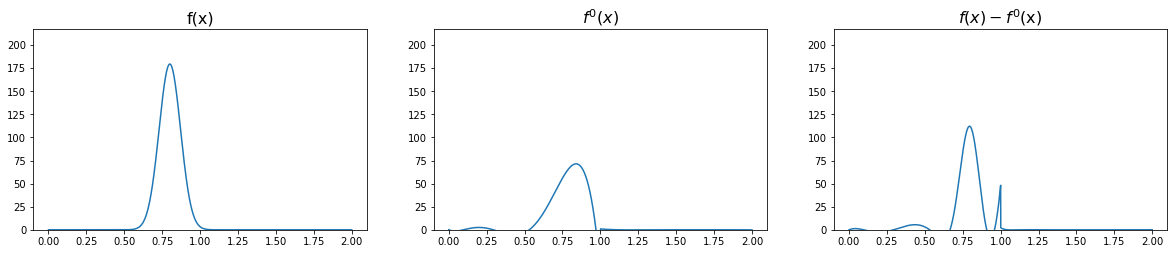

In [11]:
from plot_diff import plot_f_fn

plot_f_fn(0, f, f0, alpha*1.1)

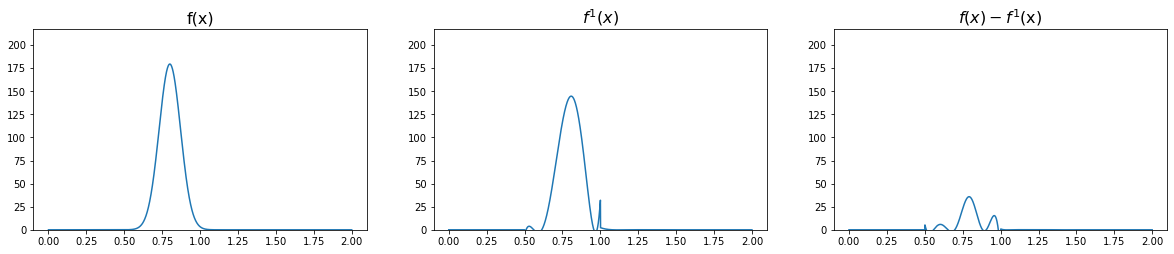

In [12]:
plot_f_fn(1, f, f1, alpha*1.1)

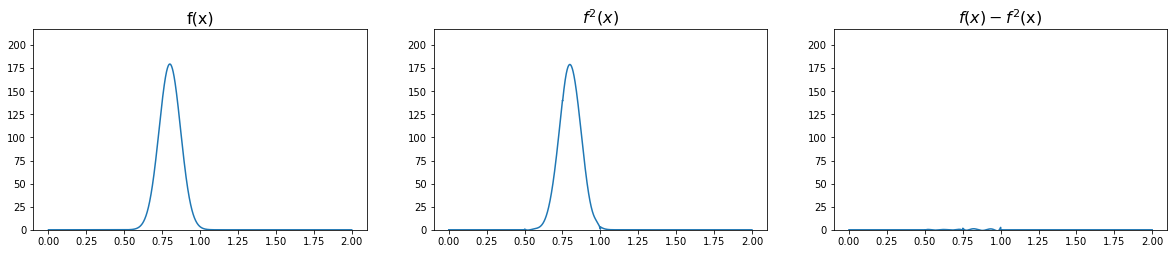

In [13]:
plot_f_fn(2, f, f2, alpha*1.1)

# Wavelet Projectors


Next let's introduce the Wavelet Projector $Q^n_k$. This operator projects the function $f$ onto the
wavelet basis $\{\psi_{j,l}^n\}$. I.e.,

\begin{align}
df^n(x) = Q^n_k [f(x)] = \sum_{l=0}^{2^n-1} \sum_{j=0}^k w_{j, l}^{n,f} \psi_{j,l}^n(x) 
\end{align}


The Wavelet Projector $Q^n_k$ is related to the Scaling Projector $P^n_k$ through the relation 

\begin{align}
P^{n+1}_k = P^n_k + Q^n_k
\end{align}

This leads to the following relation

\begin{align}
P^{n+1}_k = P^0_k + Q^n_k + Q^{n-1}_k +... + Q^0_k
\end{align}


Which means we can write the function projection $f^N$ as 


\begin{align}
f^N(x) = P^0_k [f(x)] + \sum_{n=0}^N Q^n_k [f(x)]
\end{align}


In [14]:
Q0 = vp.WaveletProjector(mra, 0) # Q^0_k
Q1 = vp.WaveletProjector(mra, 1) # Q^1_k
Q2 = vp.WaveletProjector(mra, 2) # Q^2_k
Q3 = vp.WaveletProjector(mra, 3) # Q^3_k
Q4 = vp.WaveletProjector(mra, 4) # Q^4_k

df0 = Q0(f) #df^0 = Q^0_k[f]
df1 = Q1(f) #df^0 = Q^0_k[f]
df2 = Q2(f) #df^0 = Q^0_k[f]
df3 = Q3(f) #df^0 = Q^0_k[f]
df4 = Q4(f) #df^0 = Q^0_k[f]

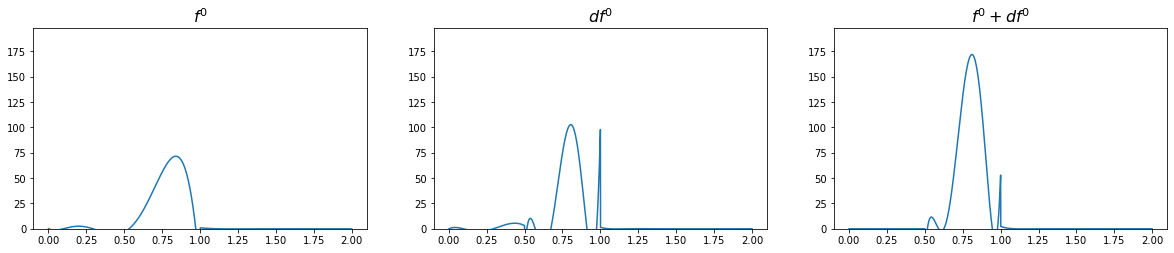

In [15]:
from plot_diff import plot_fn_df
plot_fn_df(0, f0, df0, alpha)

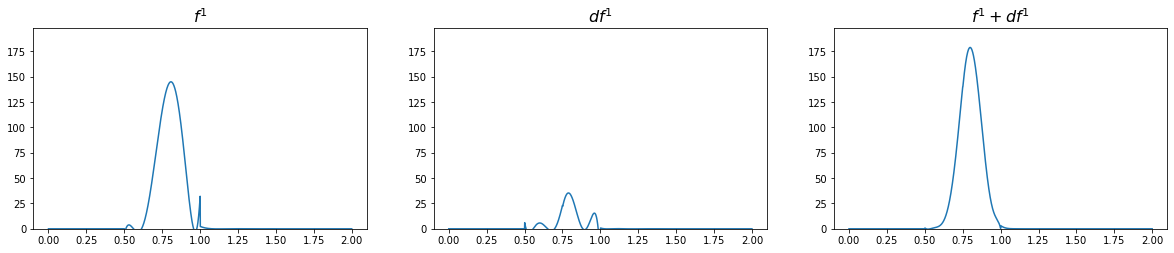

In [16]:
plot_fn_df(1, f1, df1, alpha)

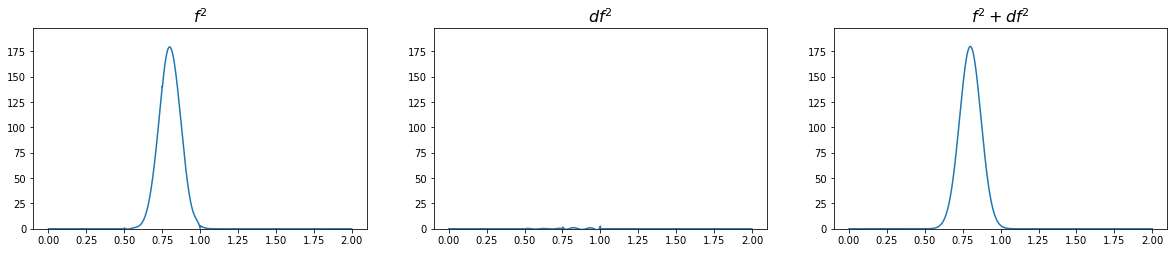

In [17]:
plot_fn_df(2, f2, df2, alpha)

Next, we can try to look at some Adaptivity. Luca mentioned that we have very good error control,
this can be employed to drastically reduce the work we need to do on our functions, while at the same time have high precision

This is what happens when we apply adaptivity to our projector

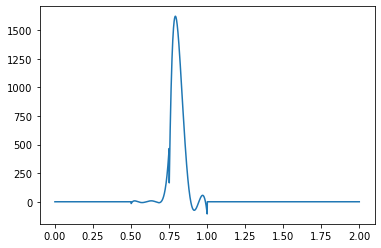

In [25]:
r0 = [0.8, 0.8, 0.8]
beta = 500.0 # Do 500 then compare with P4
alpha = (beta / np.pi) ** (3 / 2.0)
f = vp.GaussFunc(coef=alpha, exp=beta, pos=r0)

P_eps = vp.ScalingProjector(mra, prec=1.0e-3)
P2 = vp.ScalingProjector(mra, 2)
P4 = vp.ScalingProjector(mra, 4)
f_eps = P_eps(f)
f2 = P2(f)
f4 = P4(f)

x = np.arange(0.0, 2.0, 0.001)
y = [f2([x, 0.8, 0.8]) for x in x]
plt.plot(x, y)

In [26]:
print(f2)


*FunctionTree: nn
  genNodes: 0
  square norm: 710.119
  root scale: -1
  order: 5
  nodes: 585
  endNodes: 512
  nodes per scale: 
    scale=-1  nodes=1
    scale=0  nodes=8
    scale=1  nodes=64
    scale=2  nodes=512



In [27]:
print(f_eps)


*FunctionTree: nn
  genNodes: 0
  square norm: 709.88
  root scale: -1
  order: 5
  nodes: 305
  endNodes: 267
  nodes per scale: 
    scale=-1  nodes=1
    scale=0  nodes=8
    scale=1  nodes=8
    scale=2  nodes=8
    scale=3  nodes=64
    scale=4  nodes=216



(<Figure size 900x900 with 1 Axes>, <Axes3DSubplot:>)

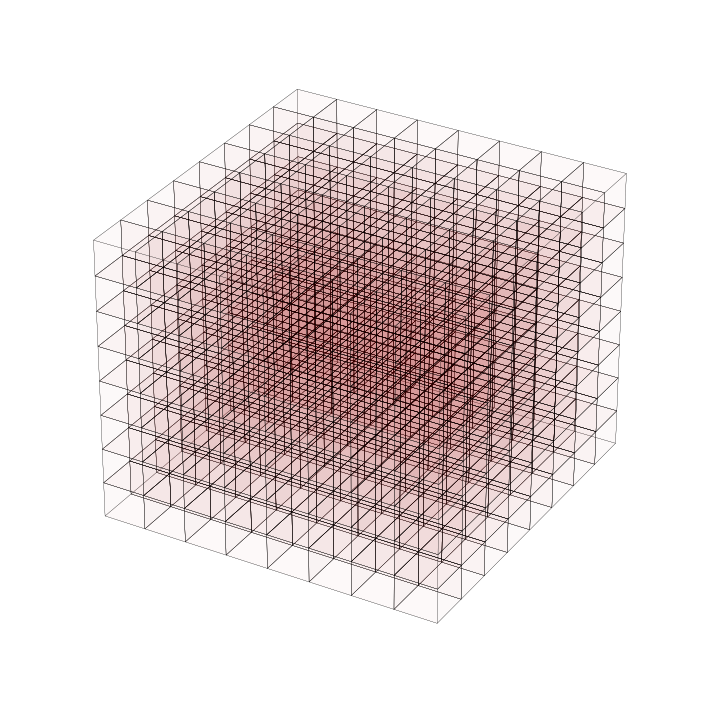

In [28]:
from grid_plotter import grid_plotter

# Uniform grid (DO f2 not f4, you'll blow up your laptop)


(<Figure size 900x900 with 1 Axes>, <Axes3DSubplot:>)

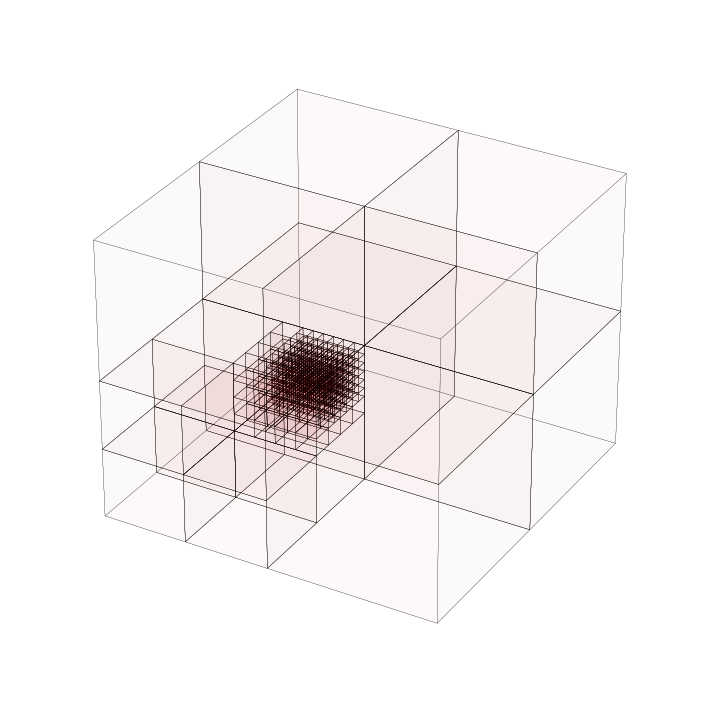

In [29]:
grid_plotter(f_eps)